In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal, Constant
from utils_functions import *
from plan import *
import random
from main import *
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.layers import LSTM
#from tensorflow.keras.layers import RepeatVector
#from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.utils  import plot_model
#from tensorflow.keras.utils  import Sequence
from sklearn.model_selection import train_test_split
import datetime, os
import pandas as pd

import optuna
from optuna.multi_objective.study import create_study
from optuna import *

In [2]:
# controllo di star effettivamente usando la GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print("nome gpu: ",tf.test.gpu_device_name())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
nome gpu:  /device:GPU:0


## Preparazione dati

### Preparazione dati per struttura Simil-CBOW

Creazione dataset

In [ ]:
dizionario_stati = load_file("./dizionario_stati")
piani_caricati = load_file("./plans")

In [ ]:
#ESEMPIO DI TEST
d = [
    [[0,0,0,0],[0,0,0,1],[0,0,0,2],[0,0,0,3],[0,0,0,4],[0,0,0,5],[0,0,0,6],[0,0,0,7]],
    [[1,1,1,0],[1,1,1,1],[1,1,1,2],[1,1,1,3],[1,1,1,4],[1,1,1,5],[1,1,1,6],[1,1,1,7],[1,1,1,8],[1,1,1,9]],
    [[2,2,2,0],[2,2,2,1],[2,2,2,2],[2,2,2,3],[2,2,2,4]],
    [[3,3,3,0],[3,3,3,1],[3,3,3,2],[3,3,3,3]],
    [[4,4,4,0],[4,4,4,1],[4,4,4,2],[4,4,4,3],[4,4,4,4],[4,4,4,5]]

]

In [ ]:
new = dataset_augmentation(d)

In [ ]:
print(new)
print(new.shape)

# Processo creazione dateset corretti

In [ ]:
dataset = costruisci_vettore_per_piano(dizionario_stati,piani_caricati)

dataset_5x340 = dataset_augmentation(dataset)

In [ ]:
print(dataset_5x340.shape)

In [ ]:
np.random.shuffle(dataset_5x340)

In [ ]:
df = pd.DataFrame(dataset_5x340.tolist(), columns=['s0', 's1','s2','s3','s4'])

In [ ]:
df

In [ ]:
X=df[["s0","s1","s3","s4"]]

In [ ]:
Y=df["s2"]

In [ ]:
#split
x_tmp, x_test, y_tmp, y_test = train_test_split(X,Y,test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x_tmp,y_tmp,test_size = 0.25,train_size =0.75)

In [ ]:
x_train


In [ ]:
y_train

In [ ]:
x_test

In [ ]:
y_test

In [ ]:
x_train=x_train.to_numpy(dtype=object)
y_train=y_train.to_numpy(dtype=object)

x_val=x_val.to_numpy(dtype=object)
y_val=y_val.to_numpy(dtype=object)

x_test=x_test.to_numpy(dtype=object)
y_test=y_test.to_numpy(dtype=object)


In [ ]:
#Metodi usati per ri-trasformare tutti gli array/liste in np array con np.int8
def convert_x_np(data):
    new_data=[]
    for seq in data:
        new_seq=[]
        for array in seq:
            np_a=np.array(array,dtype=np.int8)
            new_seq.append(np_a)
        np_seq=np.array(new_seq)
        new_data.append(np_seq)
    np_new_data=np.array(new_data)
    return np_new_data  

def convert_y_np(data):
    new_data=[]
    for array in data:
        np_a=np.array(array,dtype=np.int8)
        new_data.append(np_a) 
               
    np_new_data=np.array(new_data)
    print("Completato")
    return np_new_data  


In [ ]:
np_x_train=convert_x_np(x_train)
np_y_train=convert_y_np(y_train)

np_x_val=convert_x_np(x_val)
np_x_test=convert_x_np(x_test)

np_y_val=convert_y_np(y_val)
np_y_test=convert_y_np(y_test)

In [ ]:
save_file(np_x_train, "./Dataset/", "set_training_x")
save_file(np_x_val, "./Dataset/", "set_validation_x")
save_file(np_x_test, "./Dataset/", "set_test_x")
    
save_file(np_y_train, "./Dataset/", "set_training_y")
save_file(np_y_val, "./Dataset/", "set_validation_y")
save_file(np_y_test, "./Dataset/", "set_test_y")

# Modello

Caricamento dataset

In [3]:
train_x=load_file("./Dataset/set_training_x")
train_y=load_file("./Dataset/set_training_y")
val_x=load_file("./Dataset/set_validation_x")
val_y=load_file("./Dataset/set_validation_y")
test_x=load_file("./Dataset/set_test_x")
test_y=load_file("./Dataset/set_test_y")

File loaded
File loaded
File loaded
File loaded
File loaded
File loaded


## Optuna

In [ ]:
def objective(trial):
    
    logdir = os.path.join("./TestLogs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True, write_images=True)
    ]
    
    param={"INPUT_SIZE" : "4,340" ,
    "OUTPUT_SIZE":340,
    "HIDDEN_SIZE" : 670,
    "HIDDEN_SIZE2" : 134,
    "HIDDEN_SIZE3" : None,
    "CODE_SIZE" : 67,
    "KERNEL_INIZIALIZER":"he_uniform",
    #"KERNEL_REGULIZER":tf.keras.regularizers.L2(l2=1e-5),
    'BIAS_REGULARIZER': None,
    "ACTIVATION":'relu',
    #"OPTIMIZER":tf.keras.optimizers.Adam(learning_rate=0.0002),
    "EPOCHS":400,
    "BATCH_SIZE":150,
    "BATCH_NORMAIZATION": 0
    }
    
    autoencoderV2=tf.keras.models.Sequential()
    
    l_rate = trial.suggest_float("learning rate", 1e-5, 5e-5, log = True)
    regolarizzatore = trial.suggest_float("reg param", 1e-5, 5e-5, log = True)
    
    autoencoderV2.add(Input(shape=(4,340)))
    autoencoderV2.add(Flatten())
    autoencoderV2.add( Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"], kernel_regularizer=tf.keras.regularizers.L2(regolarizzatore), bias_regularizer=param["BIAS_REGULARIZER"] ))
    autoencoderV2.add( Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"], kernel_regularizer=tf.keras.regularizers.L2(regolarizzatore), bias_regularizer=param["BIAS_REGULARIZER"] ))
    autoencoderV2.add(Dense(param["CODE_SIZE"], activation=param["ACTIVATION"],kernel_initializer=param["KERNEL_INIZIALIZER"], kernel_regularizer=tf.keras.regularizers.L2(regolarizzatore), bias_regularizer=param["BIAS_REGULARIZER"],name="embedding"))
    autoencoderV2.add( Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"], kernel_regularizer=tf.keras.regularizers.L2(regolarizzatore), bias_regularizer=param["BIAS_REGULARIZER"] ))
    autoencoderV2.add(Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"], kernel_regularizer=tf.keras.regularizers.L2(regolarizzatore), bias_regularizer=param["BIAS_REGULARIZER"] ))
    autoencoderV2.add( Dense(param["OUTPUT_SIZE"], activation='sigmoid'))
    
    autoencoderV2.compile(optimizer=tf.keras.optimizers.Adam(l_rate), loss='binary_crossentropy',metrics=["accuracy","Precision","Recall"])
    history=autoencoderV2.fit(x=train_x,y=train_y, epochs=param["EPOCHS"],batch_size=param["BATCH_SIZE"], validation_data=(val_x,val_y), 
                        callbacks=my_callbacks)
    optuna_dir= os.path.join("./optunaLogs_parte2/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    optuna_dir=os.path.join(optuna_dir, str(trial.number))
    autoencoderV2.save(optuna_dir)

    return history.history["loss"][-1]

    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15, timeout=None, gc_after_trial=True)

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


## Modello simil-CBOW

In [40]:
logdir = os.path.join("./TestLogs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True, write_images=True)

]



#PARAM:
#tf.keras.regularizers.L1(l1=1e-4)
param={"INPUT_SIZE" : "4,340" ,
"OUTPUT_SIZE":340,
"HIDDEN_SIZE" : 670,
"HIDDEN_SIZE2" : 134,
"HIDDEN_SIZE3" : None,
"CODE_SIZE" : 67,
"KERNEL_INIZIALIZER":"he_uniform",
"KERNEL_REGULIZER":tf.keras.regularizers.L2(l2=5e-6),
'BIAS_REGULARIZER': None,
"ACTIVATION":'relu',
"OPTIMIZER":tf.keras.optimizers.Adam(learning_rate=7e-5),
"EPOCHS":800,
"BATCH_SIZE":150,
# "BATCH_NORMALIZATION": 0
}

autoencoderV2=tf.keras.models.Sequential()

autoencoderV2.add(Input(shape=(4,340)))

autoencoderV2.add(Flatten())

autoencoderV2.add( Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
autoencoderV2.add(tf.keras.layers.BatchNormalization())
autoencoderV2.add( Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
autoencoderV2.add(tf.keras.layers.BatchNormalization())
autoencoderV2.add(Dense(param["CODE_SIZE"], activation=param["ACTIVATION"],kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"],bias_regularizer=param["BIAS_REGULARIZER"],name="embedding"))
autoencoderV2.add(tf.keras.layers.BatchNormalization())
autoencoderV2.add( Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
autoencoderV2.add(tf.keras.layers.BatchNormalization())
autoencoderV2.add(Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
autoencoderV2.add(tf.keras.layers.BatchNormalization())
autoencoderV2.add( Dense(param["OUTPUT_SIZE"], activation='sigmoid'))


#variare learning_rate beta_1,beta_2, da fare per ultimo
#batch_size ???
autoencoderV2.compile(optimizer=param["OPTIMIZER"], loss='binary_crossentropy',metrics=["accuracy","Precision","Recall"])
history=autoencoderV2.fit(x=train_x,y=train_y, epochs=param["EPOCHS"],batch_size=param["BATCH_SIZE"], validation_data=(val_x,val_y), 
                        callbacks=my_callbacks)

Epoch 1/800
1025/1025 [==============================] - 17s 15ms/step - loss: 0.4910 - accuracy: 0.0377 - precision: 0.1049 - recall: 0.4298 - val_loss: 0.1923 - val_accuracy: 0.0557 - val_precision: 0.7177 - val_recall: 0.2123
Epoch 2/800
1025/1025 [==============================] - 12s 12ms/step - loss: 0.1507 - accuracy: 0.0700 - precision: 0.7798 - recall: 0.2777 - val_loss: 0.1265 - val_accuracy: 0.0723 - val_precision: 0.8277 - val_recall: 0.3701
Epoch 3/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.1146 - accuracy: 0.0710 - precision: 0.8349 - recall: 0.4417 - val_loss: 0.1021 - val_accuracy: 0.0713 - val_precision: 0.8639 - val_recall: 0.5137
Epoch 4/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0952 - accuracy: 0.0678 - precision: 0.8703 - recall: 0.5522 - val_loss: 0.0862 - val_accuracy: 0.0651 - val_precision: 0.8923 - val_recall: 0.6066
Epoch 5/800
1025/1025 [==============================] - 12s 11ms/step - loss: 0.081

Epoch 36/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0111 - accuracy: 0.0885 - precision: 0.9907 - recall: 0.9804 - val_loss: 0.0134 - val_accuracy: 0.0895 - val_precision: 0.9857 - val_recall: 0.9760
Epoch 37/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0107 - accuracy: 0.0920 - precision: 0.9910 - recall: 0.9812 - val_loss: 0.0131 - val_accuracy: 0.0958 - val_precision: 0.9861 - val_recall: 0.9765
Epoch 38/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0104 - accuracy: 0.0939 - precision: 0.9913 - recall: 0.9821 - val_loss: 0.0129 - val_accuracy: 0.0891 - val_precision: 0.9865 - val_recall: 0.9768
Epoch 39/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0101 - accuracy: 0.0959 - precision: 0.9916 - recall: 0.9828 - val_loss: 0.0127 - val_accuracy: 0.1026 - val_precision: 0.9861 - val_recall: 0.9778
Epoch 40/800
1025/1025 [==============================] - 11s 11ms/step - loss: 

Epoch 72/800
1025/1025 [==============================] - 11s 10ms/step - loss: 0.0053 - accuracy: 0.1974 - precision: 0.9956 - recall: 0.9930 - val_loss: 0.0093 - val_accuracy: 0.2020 - val_precision: 0.9885 - val_recall: 0.9850
Epoch 73/800
1025/1025 [==============================] - 11s 10ms/step - loss: 0.0052 - accuracy: 0.1977 - precision: 0.9957 - recall: 0.9932 - val_loss: 0.0093 - val_accuracy: 0.2167 - val_precision: 0.9888 - val_recall: 0.9849
Epoch 74/800
1025/1025 [==============================] - 11s 10ms/step - loss: 0.0051 - accuracy: 0.2000 - precision: 0.9957 - recall: 0.9933 - val_loss: 0.0092 - val_accuracy: 0.2147 - val_precision: 0.9887 - val_recall: 0.9850
Epoch 75/800
1025/1025 [==============================] - 11s 10ms/step - loss: 0.0051 - accuracy: 0.2049 - precision: 0.9958 - recall: 0.9935 - val_loss: 0.0092 - val_accuracy: 0.2159 - val_precision: 0.9888 - val_recall: 0.9852
Epoch 76/800
1025/1025 [==============================] - 11s 10ms/step - loss: 

1025/1025 [==============================] - 11s 11ms/step - loss: 0.0037 - accuracy: 0.2907 - precision: 0.9967 - recall: 0.9954 - val_loss: 0.0081 - val_accuracy: 0.2973 - val_precision: 0.9898 - val_recall: 0.9868
Epoch 108/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0036 - accuracy: 0.2941 - precision: 0.9968 - recall: 0.9956 - val_loss: 0.0082 - val_accuracy: 0.2885 - val_precision: 0.9897 - val_recall: 0.9869
Epoch 109/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0036 - accuracy: 0.2951 - precision: 0.9967 - recall: 0.9955 - val_loss: 0.0081 - val_accuracy: 0.2883 - val_precision: 0.9902 - val_recall: 0.9867
Epoch 110/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0036 - accuracy: 0.3014 - precision: 0.9967 - recall: 0.9956 - val_loss: 0.0081 - val_accuracy: 0.2892 - val_precision: 0.9899 - val_recall: 0.9868
Epoch 111/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0035 - 

1025/1025 [==============================] - 11s 11ms/step - loss: 0.0029 - accuracy: 0.3578 - precision: 0.9972 - recall: 0.9963 - val_loss: 0.0076 - val_accuracy: 0.3729 - val_precision: 0.9907 - val_recall: 0.9874
Epoch 143/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0029 - accuracy: 0.3604 - precision: 0.9972 - recall: 0.9965 - val_loss: 0.0076 - val_accuracy: 0.3756 - val_precision: 0.9905 - val_recall: 0.9877
Epoch 144/800
1025/1025 [==============================] - 12s 12ms/step - loss: 0.0029 - accuracy: 0.3677 - precision: 0.9972 - recall: 0.9965 - val_loss: 0.0076 - val_accuracy: 0.3956 - val_precision: 0.9906 - val_recall: 0.9874
Epoch 145/800
1025/1025 [==============================] - 12s 11ms/step - loss: 0.0029 - accuracy: 0.3697 - precision: 0.9973 - recall: 0.9964 - val_loss: 0.0076 - val_accuracy: 0.3792 - val_precision: 0.9904 - val_recall: 0.9876
Epoch 146/800
1025/1025 [==============================] - 12s 12ms/step - loss: 0.0028 - 

1025/1025 [==============================] - 11s 11ms/step - loss: 0.0025 - accuracy: 0.4136 - precision: 0.9975 - recall: 0.9969 - val_loss: 0.0073 - val_accuracy: 0.4161 - val_precision: 0.9912 - val_recall: 0.9879
Epoch 178/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0025 - accuracy: 0.4169 - precision: 0.9974 - recall: 0.9968 - val_loss: 0.0073 - val_accuracy: 0.4358 - val_precision: 0.9911 - val_recall: 0.9881
Epoch 179/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0025 - accuracy: 0.4149 - precision: 0.9975 - recall: 0.9968 - val_loss: 0.0073 - val_accuracy: 0.4019 - val_precision: 0.9911 - val_recall: 0.9878
Epoch 180/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0025 - accuracy: 0.4137 - precision: 0.9974 - recall: 0.9969 - val_loss: 0.0073 - val_accuracy: 0.4352 - val_precision: 0.9908 - val_recall: 0.9882
Epoch 181/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0025 - 

1025/1025 [==============================] - 11s 11ms/step - loss: 0.0023 - accuracy: 0.4510 - precision: 0.9976 - recall: 0.9971 - val_loss: 0.0071 - val_accuracy: 0.4702 - val_precision: 0.9913 - val_recall: 0.9885
Epoch 213/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0022 - accuracy: 0.4518 - precision: 0.9976 - recall: 0.9972 - val_loss: 0.0071 - val_accuracy: 0.4516 - val_precision: 0.9913 - val_recall: 0.9885
Epoch 214/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0022 - accuracy: 0.4595 - precision: 0.9977 - recall: 0.9972 - val_loss: 0.0070 - val_accuracy: 0.4594 - val_precision: 0.9915 - val_recall: 0.9884
Epoch 215/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0022 - accuracy: 0.4600 - precision: 0.9977 - recall: 0.9972 - val_loss: 0.0071 - val_accuracy: 0.4584 - val_precision: 0.9914 - val_recall: 0.9884
Epoch 216/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0022 - 

1025/1025 [==============================] - 11s 10ms/step - loss: 0.0021 - accuracy: 0.4807 - precision: 0.9978 - recall: 0.9974 - val_loss: 0.0069 - val_accuracy: 0.5019 - val_precision: 0.9917 - val_recall: 0.9890
Epoch 248/800
1025/1025 [==============================] - 11s 10ms/step - loss: 0.0020 - accuracy: 0.4882 - precision: 0.9979 - recall: 0.9974 - val_loss: 0.0069 - val_accuracy: 0.5101 - val_precision: 0.9917 - val_recall: 0.9890
Epoch 249/800
1025/1025 [==============================] - 11s 10ms/step - loss: 0.0021 - accuracy: 0.4866 - precision: 0.9978 - recall: 0.9973 - val_loss: 0.0069 - val_accuracy: 0.4835 - val_precision: 0.9915 - val_recall: 0.9889
Epoch 250/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0021 - accuracy: 0.4854 - precision: 0.9978 - recall: 0.9973 - val_loss: 0.0069 - val_accuracy: 0.5249 - val_precision: 0.9917 - val_recall: 0.9889
Epoch 251/800
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0021 - 

In [35]:
autoencoderV2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 1360)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 670)               911870    
_________________________________________________________________
dense_26 (Dense)             (None, 134)               89914     
_________________________________________________________________
embedding (Dense)            (None, 67)                9045      
_________________________________________________________________
dense_27 (Dense)             (None, 134)               9112      
_________________________________________________________________
dense_28 (Dense)             (None, 670)               90450     
_________________________________________________________________
dense_29 (Dense)             (None, 340)              

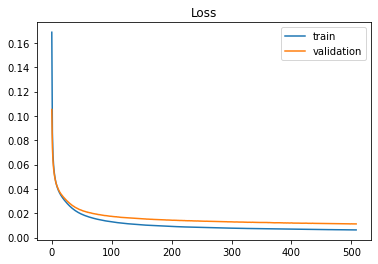

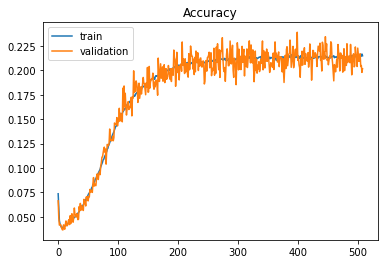

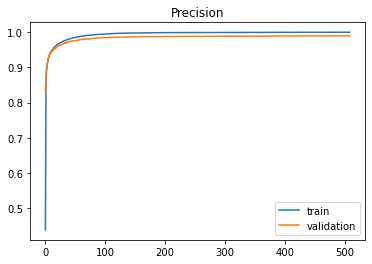

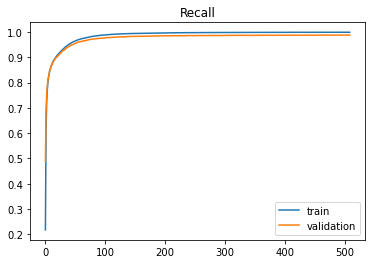

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss")
plt.show()
    
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='validation')
plt.legend()
plt.title("Precision")
plt.show()

plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='validation')
plt.legend()
plt.title("Recall")
plt.show()

In [37]:
y_test_predict= autoencoderV2.predict(test_x)


Numero di vettori decodificati correttamente: 46054 su 51231 totali 
Rapporto: 89.895% 
Media num di errori per array: 0.374



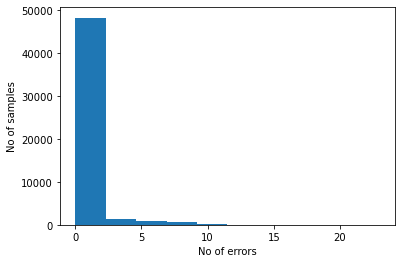

In [38]:
arr=results_info(test_y, y_test_predict,logdir)


In [39]:
#Se è buono salvare (>90% rapporto vettori decodificati correttamente)

dir_model= os.path.join(logdir,"myModel")
autoencoderV2.save(dir_model)

INFO:tensorflow:Assets written to: ./TestLogs/20220718-154318\myModel\assets
